<a href="https://colab.research.google.com/github/jiinpark21/ESAA_24-2/blob/main/3%EC%A3%BC%EC%B0%A8_%EA%B3%BC%EC%A0%9C_0916_%EC%BA%90%EA%B8%80_2_%EB%AA%A8%EB%8D%B8%ED%9B%88%EB%A0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 캐글 필사 : 모델 훈련

Stacked Regressions to predict House Prices

https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard/notebook

## 데이터 불러오기

In [4]:
# import some necessary libraries

import numpy as np    # linear algebra
import pandas as pd   # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt     # Matlab-style plotting

import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

import warnings
def ignore_warn(*args, **kwargs):
  pass
warnings.warn = ignore_warn    # ignore annoying warning (from sklearn and seaborn)

from scipy import stats
from scipy.stats import norm, skew     # for some statistics

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))   # Limiting floats output to 3 decimal points

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))    # check the files available in the directory

In [5]:
# Now let's import and put the train and test datasets in pandas dataframe

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
# display the first five rows of the train dataset.
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
# display the first five rows of the test dataset.
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [8]:
# check the numbers of samples and features
print("The train data size before dropping Id feature is : {}".format(train.shape))
print("The test data size before dropping Id feature is : {}".format(test.shape))

# Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

# Now drop the 'Id' column since it's unnecessary for the prediction process.
train.drop("Id", axis=1, inplace=True)
test.drop("Id", axis=1, inplace=True)

# Check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {}".format(train.shape))
print("The test data size after dropping Id feature is : {}".format(test.shape))

The train data size before dropping Id feature is : (1460, 81)
The test data size before dropping Id feature is : (1459, 80)

The train data size after dropping Id feature is : (1460, 80)
The test data size after dropping Id feature is : (1459, 79)


## Data Processing

### Outliers

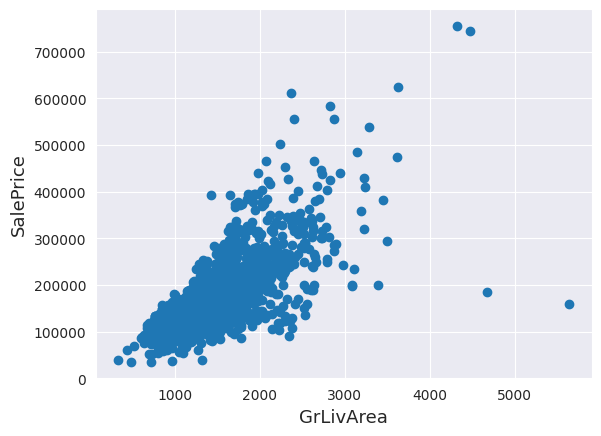

In [9]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

- 그래프 오른쪽 아래에 이상치 존재 -> 삭제

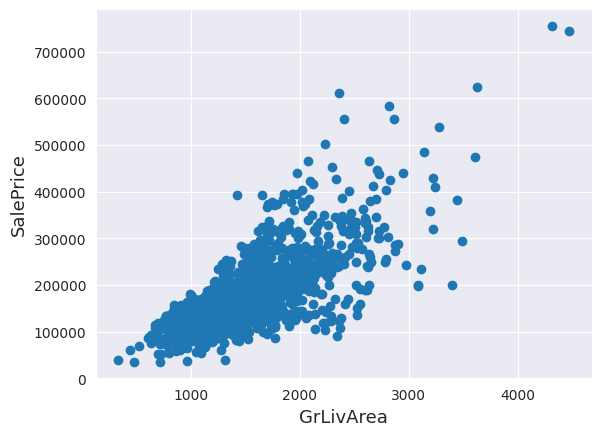

In [10]:
# Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

# Check the graphic again
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

### Target Variable

- SalePrice : 예측하고자 하는 변수


 mu = 180932.92 and sigma = 79467.79



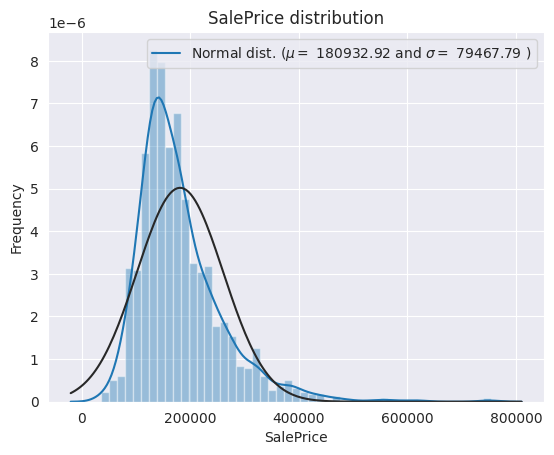

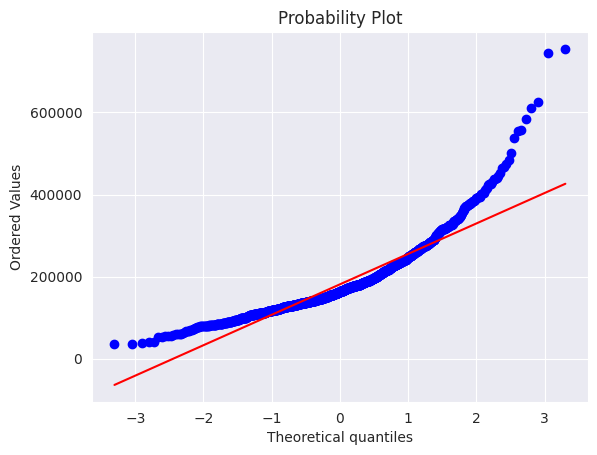

In [11]:
sns.distplot(train['SalePrice'], fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

- target value가 right skewed되어 있으며, 정규분포를 따르도록 변환할 필요가 있음

#### Log-transformation of the target variable


 mu = 12.02 and sigma = 0.40



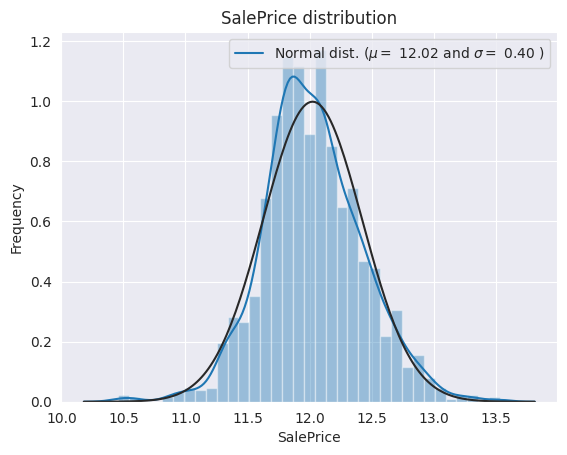

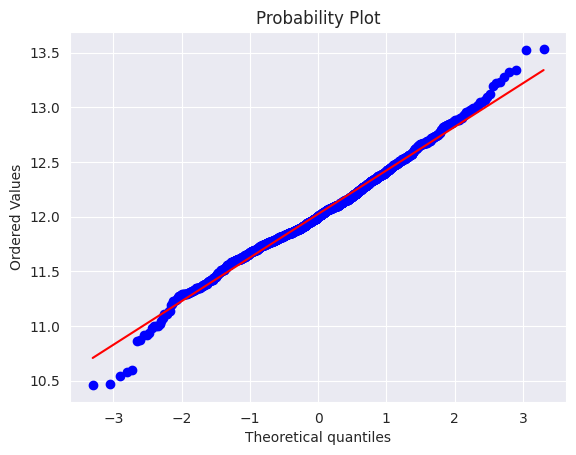

In [12]:
# We use the numpy function log1p which applies log(1+x) to all elements of the column
train['SalePrice'] = np.log1p(train['SalePrice'])

# Check the new distribution
sns.distplot(train['SalePrice'], fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

- 로그 변환 후, 왜곡된 데이터가 수정 되었으며 정규 분포와 가까워짐

### Features engineering

In [13]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


#### Missing Data

In [14]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' : all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
MasVnrType,60.542
FireplaceQu,48.680
LotFrontage,16.661
GarageFinish,5.451
GarageQual,5.451
GarageCond,5.451


Text(0.5, 1.0, 'Percent missing data by feature')

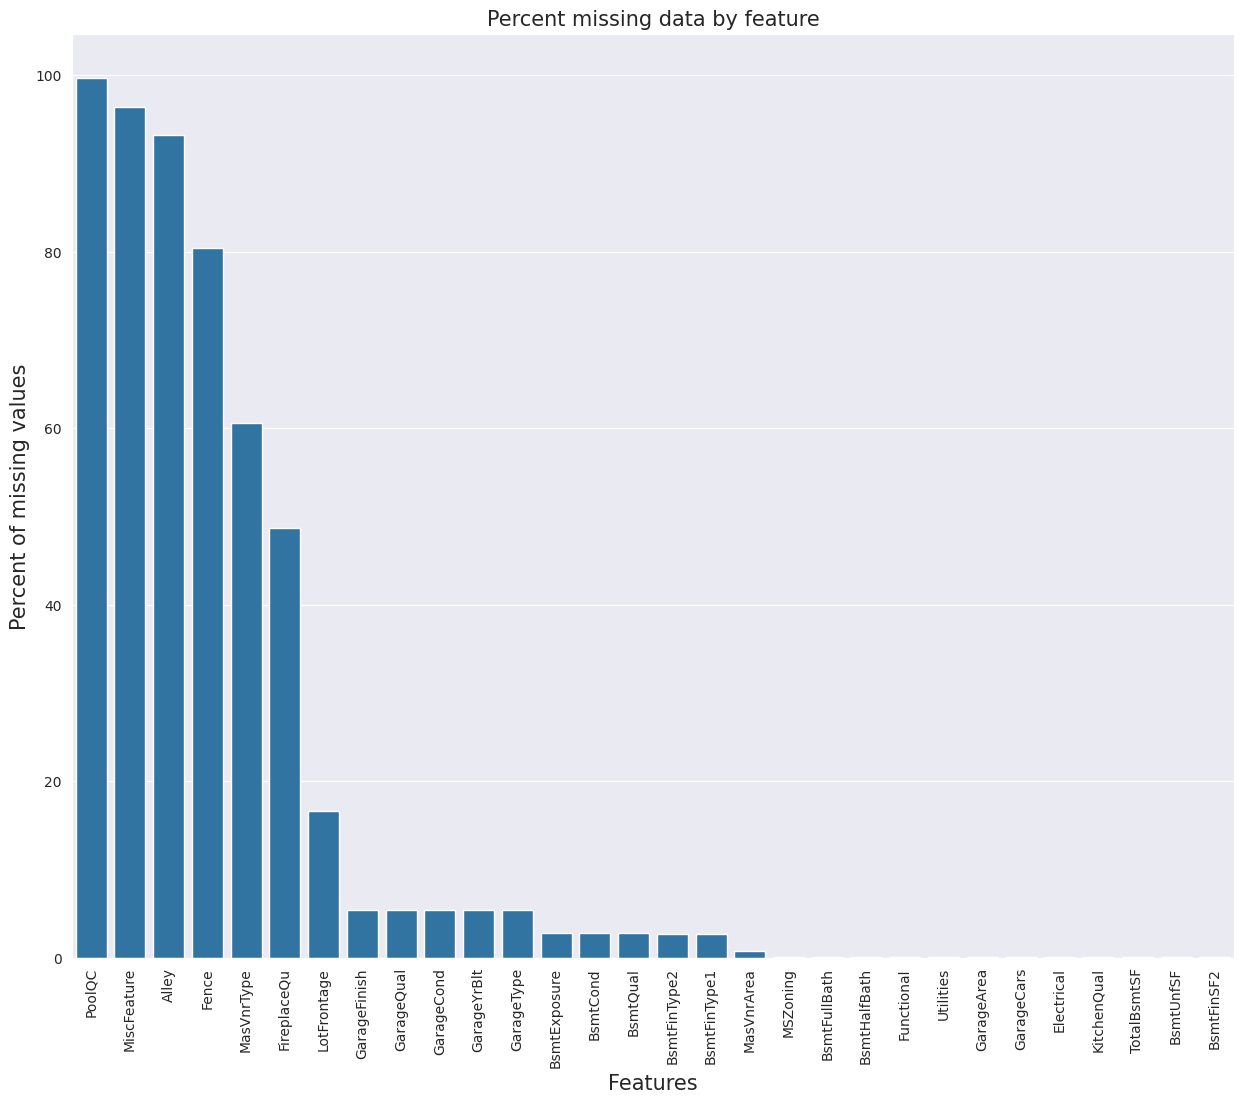

In [15]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation=90)
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

#### Data Correlation

<Axes: >

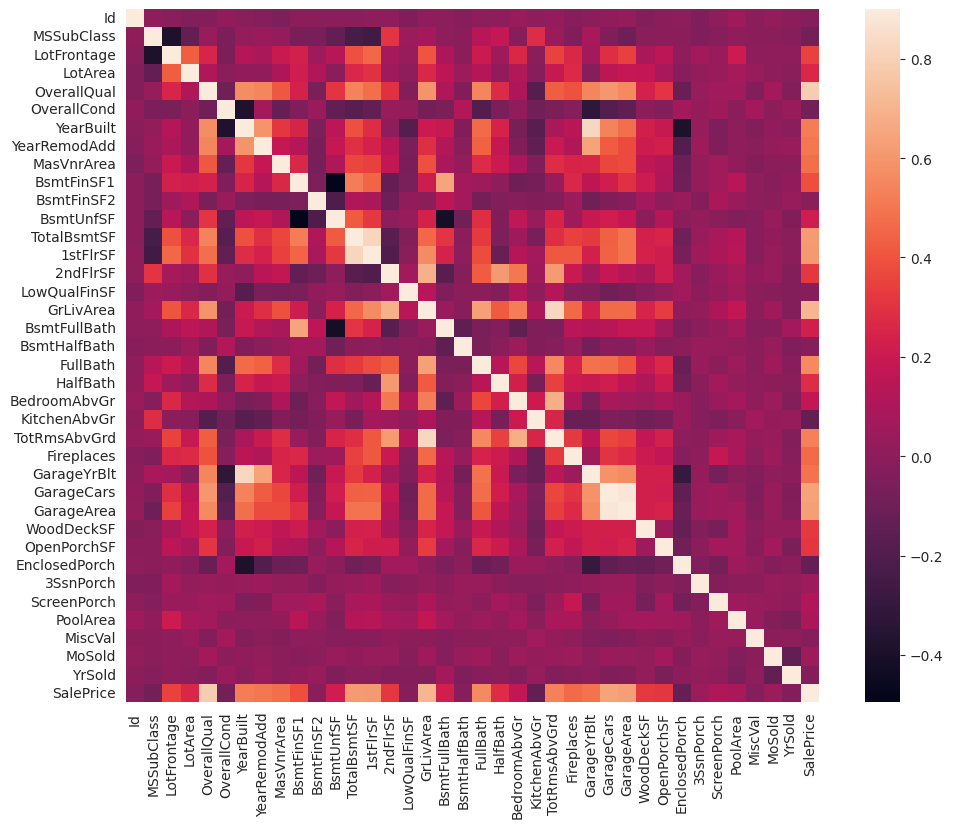

In [3]:
# Correlation map to see how features are correlated with SalePrice
corrmat = train.corr(numeric_only=True)
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.9, square=True)

#### Imputing missing values

- missing value를 none으로 대체

In [ ]:
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')

In [ ]:
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')

In [ ]:
all_data['Alley'] = all_data['Alley'].fillna('None')

In [ ]:
all_data['Fence'] = all_data['Fence'].fillna('None')

In [ ]:
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('None')

- missing value를 이웃 LotFrontage의 중간값으로 대체

In [ ]:
# Group by neighborhood and fill in missing values by the median LotFrontage of all the neighborhood
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

- missing value를 none으로 대체

In [ ]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
  all_data[col] = all_data[col].fillna('None')

- missing value를 0으로 대체

In [ ]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
  all_data[col] = all_data[col].fillna(0)

In [ ]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
  all_data[col] = all_data[col].fillna(0)

- missing value를 none으로 대체

In [ ]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
  all_data[col] = all_data[col].fillna('None')

In [ ]:
all_data['MasVnrType'] = all_data['MasVnrType'].fillna('None')
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)

- missing value를 최빈값인 'RL'로 대체

In [ ]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

- 모델링에 필요 없으므로 삭제

In [ ]:
all_data = all_data.drop(['Utilities'], axis=1)

- missing value를 'Typ'으로 대체

In [ ]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

- missing value를 최빈값으로 대체

In [ ]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

In [ ]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

In [ ]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

In [ ]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

- missing value를 none으로 대체

In [ ]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [ ]:
#Check remaining missing values if any
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


- missing value 없음

#### Transforming some numerical variables that are really categorical

In [ ]:
# MSSubClass = The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

# Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

# Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

#### Label Encoding some categorical variables that may contain information in their ordering set

In [ ]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond',
        'YrSold', 'MoSold')

# process columns, apply LabelEncoder to categorical features
for c in cols:
  lbl = LabelEncoder()
  lbl.fit(list(all_data[c].values))
  all_data[c] = lbl.transform(list(all_data[c].values))

# shape
print('Shape all_data : {}'.format(all_data.shape))

Shape all_data : (2917, 78)


#### Adding one more important feature

- 면적과 관련된 feature는 집 가격을 결정하는데 중요한 요소이므로, 각 주택의 총 면적을 구해 'TotalSF'로 추가

In [ ]:
# Adding total sqfootage feature
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

#### Skewed features

In [ ]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index


# Check the skew of all numerical fetures
skewed_feats = all_data[numeric_feats].apply(lambda x : skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


#### Box Cox Transformation of (highly) skewed features

In [ ]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features :
  # all_data[feat] += 1
  all_data[feat] = boxcox1p(all_data[feat], lam)

# all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 59 skewed numerical features to Box Cox transform


#### Getting dummy categorical features

In [ ]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


#### Getting the new train and test sets.

In [ ]:
train = all_data[:ntrain]
test = all_data[ntrain:]

## Modeling

#### Import libraries

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

#### Define a cross validation strategy

In [ ]:
# Validation function
n_folds = 5

def rmsle_cv(model):
  kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
  rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv=kf))
  return(rmse)

### Base models

- Lasso Regression : outlier에 민감 -> RobustScaler() 사용

In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))

- Elastic Net Regression : again made robust to outliers(RobustScaler())

In [ ]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

- Kernel Ridge Regression

In [ ]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

- Gradient Boosting Regression : 이상치에 영향을 받지 않도록 'huber' loss 사용

In [ ]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, loss='huber', random_state=5)

- XGBoost

In [ ]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state=7, nthread=-1)

- LightGBM

In [ ]:
model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin=55, bagging_fraction=0.8,
                              bagging_freq=5, feature_fraction=0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf=6, min_sum_hessian_in_leaf=11)

#### Base models scores

- cross-validation rmsle 사용하여 모델 평가

In [ ]:
score = rmsle_cv(lasso)
print("\nLasso score : {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score : 0.1115 (0.0074)



In [ ]:
score = rmsle_cv(ENet)
print("ElasticNet score : {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score : 0.1116 (0.0074)



In [ ]:
score = rmsle_cv(KRR)
print("Kernel Ridge score : {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score : 0.1153 (0.0075)



In [ ]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score : {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score : 0.1167 (0.0083)



In [ ]:
score = rmsle_cv(model_xgb)
print("Xgboost Boosting score : {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost Boosting score : 0.1167 (0.0068)



In [ ]:
score = rmsle_cv(model_lgb)
print("LGBM score : {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319

### Stacking models

#### Averaged base models class

- 가장 간단한 Stacking 방식 : base model 평균화

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
  def __init__(self, models):
    self.models = models

  # we define clones of the original models to fit the data in
  def fit(self, X, y):
    self.models_ = [clone(x) for x in self.models]

    # Train cloned base models
    for model in self.models_:
      model.fit(X, y)
    return self

  def predict(self, X):
    predictions = np.column_stack([
        model.predict(X) for model in self.models_
    ])
    return np.mean(predictions, axis=1)

#### Averaged base models score

- ENet, GBoost, KRR, lasso 를 평균

In [ ]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score : {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score : 0.1087 (0.0077)



#### Stacking averaged Models Class

- Less simple Stacking : Meta-model 추가

In [ ]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)

        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    #Do the predictions of all base models on the test data and use the averaged predictions as
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

#### Stacking Averged Models Score

- ENet, GBoost, KRR 모델 평균화 후, meta_model로 lasso 추가

In [ ]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR), meta_model=lasso)
score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1081 (0.0073)


### Ensembling StackedRegressor, XGBoost and LightGBM

In [ ]:
def rmsle(y, y_pred):
  return np.sqrt(mean_squared_error(y, y_pred))

#### Final Training and Prediction

- StackedRegressor

In [ ]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.07839506096665937


- XGBoost

In [ ]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.0866951518038854


- LightGBM

In [ ]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.23

In [ ]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train, stacked_train_pred*0.70 + xgb_train_pred*0.15 + lgb_train_pred*0.15))

RMSLE score on train data:
0.07653967781115523


In [ ]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv', index=False)